In [1]:
from __future__ import division 

import gym
import numpy as np
import random
import tensorflow as tf 
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
import sys
%matplotlib inline

In [2]:
from gridworld_v03_1 import gameEnv
env = gameEnv(partial=False, size=10)

In [3]:
class Qnetwork():
    def __init__(self, h_size, name = "main"):
        self.h_size = h_size
        self.net_name = name
        
        self.build_network()
        
    def build_network (self): #// h_size is the number of activation of conv4 
        #The network recieves a frame from the game, flattened into an array.
      
    #    self.scalarInput = tf.placeholder(shape=[None,84*84*3], dtype=tf.float32)
    #    self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
        
        with tf.variable_scope(self.net_name):
            # Input(return value of env.reset) dimension
            # self.dimX = env.?

            self.dimX = len(env.objects) * 2
            self.dimY = env.actions

            # Dimensions of each layer 
            self.nInputLayer = self.dimX
            self.nHidden1 = h_size
            self.nHidden2 = (int)(h_size / 2 )
            self.nHidden3 = (int)(h_size / 4)
            self.nOutputLayer = self.dimY

            self.input = tf.placeholder(shape=[None, self.dimX], dtype=tf.float32)
            self.output = tf.placeholder(shape=[None, self.dimY], dtype=tf.float32)

            # Weights of each layer
            self.W = {
                'W1': self.init_weight("W1", [self.nInputLayer, self.nHidden1]),
                'W2': self.init_weight("W2", [self.nHidden1, self.nHidden2]),
                'W3': self.init_weight("W3", [self.nHidden2, self.nHidden3]),
                'W4': self.init_weight("W4", [self.nHidden3, self.nOutputLayer])
            }

            # Bias of each layer
            self.b = {
                'b1': self.init_bias(self.nHidden1),
                'b2': self.init_bias(self.nHidden2),
                'b3': self.init_bias(self.nHidden3),
                'b4': self.init_bias(self.nOutputLayer)
            }

            # If we need,
            self.dropProb = 0.0


            self.hidden1 = tf.nn.relu(tf.add(tf.matmul(self.input, self.W['W1']), self.b['b1']))
            # self.hidden1 = tf.nn.dropout(self.hidden1, self.dropProb)

            self.hidden2 = tf.nn.relu(tf.add(tf.matmul(self.hidden1, self.W['W2']), self.b['b2']))
            # self.hidden2 = tf.nn.dropout(self.hidden2, self.dropProb)

            self.hidden3 = tf.nn.relu(tf.add(tf.matmul(self.hidden2, self.W['W3']), self.b['b3']))
            # self.hidden3 = tf.nn.dropout(self.hidden3, self.dropProb)

            self.output = tf.add(tf.matmul(self.hidden3, self.W['W4']), self.b['b4'])

            """
            self.conv1 = slim.conv2d(inputs=self.imageIn,
                                     num_outputs=32,
                                     kernel_size=[8,8],
                                     stride=[4,4],
                                     padding='VALID', 
                                     biases_initializer = None)

            self.conv2 = slim.conv2d(inputs=self.conv1,
                                     num_outputs=64,
                                     kernel_size=[4,4],
                                     stride=[2,2],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv3 = slim.conv2d(inputs=self.conv2,
                                     num_outputs=64,
                                     kernel_size=[3,3],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)

            self.conv4 = slim.conv2d(inputs=self.conv3,
                                     num_outputs=h_size,
                                     kernel_size=[7,7],
                                     stride=[1,1],
                                     padding='VALID',
                                     biases_initializer = None)
             """

            #We take the output from the final convolutional layer and split it into separated terms: advantage & value
            # I think the input dimension of our env is 1-dim 
            self.streamAC, self.streamVC = tf.split(self.output, 2, 1)
            self.streamA = slim.flatten(self.streamAC)
            self.streamV = slim.flatten(self.streamVC)

            xavier_init = tf.contrib.layers.xavier_initializer()

            self.AW = tf.Variable(xavier_init([self.dimY//2, env.actions]))
            self.VM = tf.Variable(xavier_init([self.dimY//2, 1]))

            self.Advantage = tf.matmul(self.streamA, self.AW)
            self.Value = tf.matmul(self.streamV, self.VM)

            #Then combine to obtain the final Q-value //why substract mean from Advantage?
            self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage,axis=1, keep_dims=True))
            self.predict = tf.argmax(self.Qout, 1)

            #Obtain the loss by taking the sum of squares difference between the target and predicted Q values
            self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
            self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
            self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32) #// env.actions is probably number of actions

            self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)

            self.td_error = tf.square(self.targetQ - self.Q)
            self.loss = tf.reduce_mean(self.td_error)

            self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
            self.updateModel = self.trainer.minimize(self.loss)    
            
    def init_weight(self, name, shape):
        return tf.get_variable(name=name, shape=shape, initializer=tf.contrib.layers.xavier_initializer())

    def init_bias(self, n):
        return tf.Variable(tf.random_normal([n]))

In [4]:
class experience_buffer():
    def __init__(self, buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        if len(self.buffer) + len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
        self.buffer.extend(experience)#// remove the necesary entries to make place for new experience
        
    def sample(self, size):
        return np.reshape(np.array(random.sample(self.buffer, size)),[size,5]) # buffer is experience tuple (size 4) plus "done" signal

In [5]:
def processState(states):
    return np.reshape(states,[84*84*3])

In [6]:
def updateTargetGraph(tfVars, tau):
    total_vars = len(tfVars)
    op_holder = []
    
    for idx,var in enumerate(tfVars[0:total_vars//2]): #// select the first half of the variables (the one that belong to the action choosing net) 
        op_holder.append(
            tfVars[idx+total_vars//2].assign(
                (var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))#// basically take values from the primary net and modify then slithly with values from the second net, then return then for later use of model update 
    
    return op_holder

def updateTarget(op_holder, sess):
    for op in op_holder:
        sess.run(op)  

In [7]:
def get_copy_var_ops(*, dest_scope_name="target", src_scope_name="main"):
    op_holder = []
    
    src_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=src_scope_name)
    dest_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope=dest_scope_name)
    
    for src_var, dest_var in zip(src_vars, dest_vars):
        op_holder.append(dest_var.assign(src_var.value()))
        
    return op_holder

In [8]:
#Set all the training parameters
batch_size = 16 #Number of experiences to use for each training step
update_freq = 10 #Frequency of a train step

y = .99 #Discount factor on the target Q-values

startE = 1 #Starting chance of random action
endE = 0.1 #Final chance of random action
#anneling_steps = 10000. #Number of training steps to decrease the explorarion parameter e 
anneling_steps = 30000

#num_episodes = 3*10000 #Number of episodes of the game environmet on which to train the network
num_episodes = 30000
#pre_train_steps = 10000 #Number of random action steps before training begins
pre_train_steps = 30000

#max_epLength = 100 #Maximun allowed length of a game episode
max_epLength = 200

load_model = False #Wheter to load a saved model
path = "./log4" #Directory for checkpoints
#log_path = "./dqn_logs/logs" #Directory for logs

h_size = 512 #Number of activations of final conv layer

tau = 0.001 #Rate of update of target network values onto the primary network

#f = open(log_path,'w')

In [9]:
tf.reset_default_graph()

#Network instances
mainQN = Qnetwork(h_size, name="main")
targetQN = Qnetwork(h_size, name="target")

init = tf.global_variables_initializer()
saver = tf.train.Saver()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

#Set the rate of random action decrease
e = startE
stepDrop = (startE - endE)/anneling_steps

#Create lists to contain total reward and steps per episode
jList = []
rList = []
total_steps = 0

#Create path for checkpoints
if not os.path.exists(path):
    os.makedirs(path)

In [10]:
with tf.Session() as sess:
    sess.run(init)
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
    for i in range(num_episodes):
        if i%100 == 0:
            print("\n=====" + "Episode " + str(i) + "start =====" )
        episodeBuffer = experience_buffer()
        #Reset environment and get first new observation
        s = env.reset()
        # s = processState(s)
        d = False
        rAll = 0
        j = 0
        #The Q-Network
        while j < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trial.
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.input:[s]})[0]
            s1,r,d = env.step(a)
            #print(s1, r, d)
            #s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5])) #Save the experience to our episode buffer.
            
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
              
            rAll += r
            s = s1
            
            if d == True:
                break     
                
        if total_steps > pre_train_steps and i % (update_freq) == 1:
            for _ in range(30):
                trainBatch = myBuffer.sample(batch_size) #Get a random batch of experiences.
                #Below we perform the Double-DQN update to the target Q-values
                Q1 = sess.run(mainQN.predict,feed_dict={mainQN.input:np.vstack(trainBatch[:,3])})
                Q2 = sess.run(targetQN.Qout,feed_dict={targetQN.input:np.vstack(trainBatch[:,3])})
                end_multiplier = -(trainBatch[:,4] - 1)
                doubleQ = Q2[range(batch_size),Q1]
                targetQ = trainBatch[:,2] + (y*doubleQ * end_multiplier)
                #Update the network with our target values.
                _ = sess.run(mainQN.updateModel, \
                    feed_dict={mainQN.input:np.vstack(trainBatch[:,0]),mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
            
        updateTarget(targetOps,sess) #Set the target network to be equal to the primary network.
        myBuffer.add(episodeBuffer.buffer)
        jList.append(j)
        rList.append(rAll)
        #Periodically save the model. 
        if i % 1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
        if len(rList) % 10 == 0:
            print(total_steps,np.mean(rList[-10:]), e)
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
print("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")


=====Episode 0start =====
Saved Model
333 -1.4 1
688 -1.38 1
1348 -1.42 1
1726 -1.54 1
2167 -1.46 1
2550 -1.48 1
3189 -1.2 1
3674 -1.86 1
4097 -1.8 1
4596 -1.62 1

=====Episode 100start =====
5082 -2.06 1
5387 -0.9 1
6163 -1.78 1
6464 -1.1 1
7176 -2.1 1
7745 -1.98 1
8331 -1.34 1
8798 -1.88 1
9234 -1.48 1
9492 -1.22 1

=====Episode 200start =====
10100 -1.52 1
10484 -1.46 1
10875 -1.8 1
11505 -2.04 1
12120 -1.66 1
12424 -1.38 1
13064 -2.04 1
13333 -1.16 1
13652 -1.08 1
14310 -2.24 1

=====Episode 300start =====
14728 -1.36 1
15257 -2.46 1
15571 -1.12 1
16008 -0.88 1
16501 -1.26 1
17159 -1.58 1
17529 -1.84 1
18121 -1.8 1
19090 -2.02 1
19318 -0.78 1

=====Episode 400start =====
19926 -1.7 1
20446 -2.2 1
20756 -0.98 1
21340 -1.6 1
21772 -1.56 1
22254 -1.46 1
22629 -0.98 1
23101 -1.76 1
23761 -2.86 1
24292 -2.02 1

=====Episode 500start =====
24891 -1.78 1
25377 -1.84 1
25810 -1.52 1
26155 -1.46 1
26879 -2.06 1
27144 -1.12 1
27738 -2.38 1
28065 -1.18 1
28413 -1.02 1
28838 -1.38 1

=====Epi

280261 -3.98 0.09997000000062647
281944 -9.26 0.09997000000062647
282954 -3.7 0.09997000000062647
284108 -0.58 0.09997000000062647
285015 -1.52 0.09997000000062647
286575 -0.56 0.09997000000062647
287503 -1.56 0.09997000000062647

=====Episode 2700start =====
288342 -0.06 0.09997000000062647
289845 -1.84 0.09997000000062647
290986 -0.74 0.09997000000062647
292158 -4.0 0.09997000000062647
293675 -21.04 0.09997000000062647
294464 -3.84 0.09997000000062647
295256 -0.36 0.09997000000062647
296276 -0.18 0.09997000000062647
297184 -0.24 0.09997000000062647
298089 -0.72 0.09997000000062647

=====Episode 2800start =====
299229 -0.32 0.09997000000062647
300343 -1.3 0.09997000000062647
301617 -0.8 0.09997000000062647
302986 -7.72 0.09997000000062647
304502 -4.6 0.09997000000062647
305576 -3.98 0.09997000000062647
306924 -0.1 0.09997000000062647
307987 -0.5 0.09997000000062647
309289 -7.18 0.09997000000062647
310457 -3.98 0.09997000000062647

=====Episode 2900start =====
311778 -13.76 0.099970000

547498 -0.42 0.09997000000062647
548885 -0.46 0.09997000000062647
550318 -0.14 0.09997000000062647
551318 -0.4 0.09997000000062647
552613 -3.18 0.09997000000062647
554062 -0.46 0.09997000000062647
555227 -0.92 0.09997000000062647
556108 0.06 0.09997000000062647

=====Episode 5000start =====
Saved Model
557291 -0.24 0.09997000000062647
558669 -0.36 0.09997000000062647
559780 -2.98 0.09997000000062647
561231 -2.58 0.09997000000062647
562954 -0.76 0.09997000000062647
564425 -2.24 0.09997000000062647
565607 -0.04 0.09997000000062647
566720 -0.98 0.09997000000062647
568202 -0.84 0.09997000000062647
569293 -5.0 0.09997000000062647

=====Episode 5100start =====
570703 -0.64 0.09997000000062647
571684 0.0 0.09997000000062647
572818 -0.46 0.09997000000062647
574188 -0.16 0.09997000000062647
575225 -0.2 0.09997000000062647
576010 0.06 0.09997000000062647
577212 -0.1 0.09997000000062647
578387 -0.34 0.09997000000062647
579604 -0.44 0.09997000000062647
581203 -0.22 0.09997000000062647

=====Episod

810266 -0.54 0.09997000000062647
811103 -0.46 0.09997000000062647
812001 -0.18 0.09997000000062647
813136 -1.94 0.09997000000062647
814368 -4.1 0.09997000000062647
815702 -0.4 0.09997000000062647
816547 0.08 0.09997000000062647
817791 -0.5 0.09997000000062647
818820 -0.52 0.09997000000062647
820069 -0.04 0.09997000000062647

=====Episode 7300start =====
821120 -0.16 0.09997000000062647
822303 -0.26 0.09997000000062647
823492 -0.1 0.09997000000062647
824688 -0.18 0.09997000000062647
825456 -0.28 0.09997000000062647
826118 0.02 0.09997000000062647
827228 -0.62 0.09997000000062647
827869 -0.32 0.09997000000062647
829260 -0.34 0.09997000000062647
830137 -0.1 0.09997000000062647

=====Episode 7400start =====
831321 -0.24 0.09997000000062647
832431 -0.56 0.09997000000062647
833385 -0.48 0.09997000000062647
834503 -0.52 0.09997000000062647
835857 -0.5 0.09997000000062647
836724 -0.36 0.09997000000062647
837604 -0.3 0.09997000000062647
838615 -0.2 0.09997000000062647
839851 -4.24 0.09997000000

1060167 -0.02 0.09997000000062647
1061004 0.18 0.09997000000062647

=====Episode 9500start =====
1062062 -0.02 0.09997000000062647
1062709 0.32 0.09997000000062647
1063969 0.04 0.09997000000062647
1064801 0.1 0.09997000000062647
1065946 -0.26 0.09997000000062647
1066431 -0.3 0.09997000000062647
1067916 -0.02 0.09997000000062647
1068823 -0.2 0.09997000000062647
1070091 -0.28 0.09997000000062647
1071223 -0.68 0.09997000000062647

=====Episode 9600start =====
1072485 -0.58 0.09997000000062647
1073815 -0.34 0.09997000000062647
1075145 -0.52 0.09997000000062647
1076069 -0.36 0.09997000000062647
1077192 -0.62 0.09997000000062647
1078095 -3.26 0.09997000000062647
1079004 -0.6 0.09997000000062647
1079935 -0.18 0.09997000000062647
1081233 -0.22 0.09997000000062647
1082306 -0.24 0.09997000000062647

=====Episode 9700start =====
1083918 -0.3 0.09997000000062647
1085123 0.02 0.09997000000062647
1086540 -0.02 0.09997000000062647
1087720 -0.24 0.09997000000062647
1088946 -0.16 0.09997000000062647
10

1289019 0.04 0.09997000000062647
1289927 0.14 0.09997000000062647
1291148 -0.08 0.09997000000062647
1292160 0.22 0.09997000000062647
1293182 0.06 0.09997000000062647
1294140 0.16 0.09997000000062647
1295360 -0.1 0.09997000000062647
1296356 -0.14 0.09997000000062647
1297381 0.0 0.09997000000062647
1298440 -0.18 0.09997000000062647

=====Episode 11800start =====
1299275 -0.14 0.09997000000062647
1300001 0.2 0.09997000000062647
1301034 0.06 0.09997000000062647
1302067 -0.02 0.09997000000062647
1303166 0.12 0.09997000000062647
1303922 0.3 0.09997000000062647
1304950 0.02 0.09997000000062647
1305325 -0.18 0.09997000000062647
1306230 0.02 0.09997000000062647
1307363 0.2 0.09997000000062647

=====Episode 11900start =====
1308281 -0.1 0.09997000000062647
1308992 0.08 0.09997000000062647
1310018 0.08 0.09997000000062647
1310857 0.26 0.09997000000062647
1311553 -3.2 0.09997000000062647
1312059 0.08 0.09997000000062647
1313286 0.12 0.09997000000062647
1314325 0.34 0.09997000000062647
1315348 0.14

1497644 0.28 0.09997000000062647
1498281 0.04 0.09997000000062647
1499119 0.22 0.09997000000062647

=====Episode 14000start =====
Saved Model
1500129 -0.2 0.09997000000062647
1500774 0.44 0.09997000000062647
1501858 0.32 0.09997000000062647
1502482 0.36 0.09997000000062647
1503314 0.34 0.09997000000062647
1504102 0.3 0.09997000000062647
1504866 0.18 0.09997000000062647
1505708 0.26 0.09997000000062647
1506570 0.22 0.09997000000062647
1507408 0.5 0.09997000000062647

=====Episode 14100start =====
1508264 0.32 0.09997000000062647
1509050 0.38 0.09997000000062647
1509922 0.26 0.09997000000062647
1510760 0.44 0.09997000000062647
1511634 -0.02 0.09997000000062647
1512279 0.42 0.09997000000062647
1512983 -0.04 0.09997000000062647
1513809 0.56 0.09997000000062647
1514568 0.22 0.09997000000062647
1515434 0.5 0.09997000000062647

=====Episode 14200start =====
1516245 0.2 0.09997000000062647
1517023 0.32 0.09997000000062647
1517716 0.12 0.09997000000062647
1518537 0.44 0.09997000000062647
151937

1675555 0.0 0.09997000000062647
1676202 0.5 0.09997000000062647
1677388 0.22 0.09997000000062647
1678065 0.6 0.09997000000062647
1679114 0.32 0.09997000000062647
1679660 0.48 0.09997000000062647

=====Episode 16300start =====
1680732 0.2 0.09997000000062647
1681460 0.36 0.09997000000062647
1682382 0.42 0.09997000000062647
1683150 0.54 0.09997000000062647
1684267 0.38 0.09997000000062647
1684911 0.68 0.09997000000062647
1686023 0.54 0.09997000000062647
1686740 0.26 0.09997000000062647
1687574 0.26 0.09997000000062647
1688308 0.62 0.09997000000062647

=====Episode 16400start =====
1689257 0.56 0.09997000000062647
1689761 0.7 0.09997000000062647
1690604 0.6 0.09997000000062647
1691316 0.48 0.09997000000062647
1692369 0.42 0.09997000000062647
1693067 0.54 0.09997000000062647
1693827 0.68 0.09997000000062647
1694679 0.48 0.09997000000062647
1695631 0.46 0.09997000000062647
1696307 0.74 0.09997000000062647

=====Episode 16500start =====
1697414 0.44 0.09997000000062647
1698172 0.48 0.0999700

1853734 0.36 0.09997000000062647
1854417 0.52 0.09997000000062647
1855696 0.26 0.09997000000062647
1856316 0.64 0.09997000000062647
1857444 0.5 0.09997000000062647
1858141 0.46 0.09997000000062647
1859401 0.14 0.09997000000062647
1859906 0.6 0.09997000000062647

=====Episode 18600start =====
1861448 0.22 0.09997000000062647
1862160 0.64 0.09997000000062647
1863433 0.3 0.09997000000062647
1864191 0.76 0.09997000000062647
1865540 0.3 0.09997000000062647
1866116 0.42 0.09997000000062647
1867725 0.02 0.09997000000062647
1868576 0.38 0.09997000000062647
1869804 -0.06 0.09997000000062647
1870588 0.62 0.09997000000062647

=====Episode 18700start =====
1872083 0.22 0.09997000000062647
1872967 0.62 0.09997000000062647
1874393 0.26 0.09997000000062647
1874716 0.5 0.09997000000062647
1876146 0.1 0.09997000000062647
1877216 0.48 0.09997000000062647
1878643 0.06 0.09997000000062647
1879103 0.32 0.09997000000062647
1880357 0.14 0.09997000000062647
1880938 0.5 0.09997000000062647

=====Episode 18800s

2078221 -0.06 0.09997000000062647
2079110 0.38 0.09997000000062647
2080338 0.24 0.09997000000062647
2080894 0.54 0.09997000000062647
2082106 -0.06 0.09997000000062647
2082684 0.88 0.09997000000062647
2083911 0.02 0.09997000000062647
2084804 0.56 0.09997000000062647
2085676 0.3 0.09997000000062647
2086037 0.68 0.09997000000062647

=====Episode 20900start =====
2087264 0.02 0.09997000000062647
2087728 0.56 0.09997000000062647
2088782 0.24 0.09997000000062647
2089660 0.56 0.09997000000062647
2090895 0.02 0.09997000000062647
2091386 0.52 0.09997000000062647
2092621 0.16 0.09997000000062647
2093431 0.5 0.09997000000062647
2094660 0.14 0.09997000000062647
2095314 0.56 0.09997000000062647

=====Episode 21000start =====
Saved Model
2096347 0.16 0.09997000000062647
2096944 0.64 0.09997000000062647
2097824 0.1 0.09997000000062647
2098944 0.48 0.09997000000062647
2100014 0.22 0.09997000000062647
2100723 0.34 0.09997000000062647
2101757 0.1 0.09997000000062647
2102432 0.38 0.09997000000062647
2103

2294166 0.36 0.09997000000062647
2295040 0.08 0.09997000000062647
2295615 0.76 0.09997000000062647

=====Episode 23100start =====
2296845 0.24 0.09997000000062647
2297198 0.86 0.09997000000062647
2298432 0.4 0.09997000000062647
2299356 0.38 0.09997000000062647
2300421 0.2 0.09997000000062647
2301132 0.64 0.09997000000062647
2302278 0.22 0.09997000000062647
2303001 0.42 0.09997000000062647
2303885 -1.7 0.09997000000062647
2304275 0.84 0.09997000000062647

=====Episode 23200start =====
2305472 0.16 0.09997000000062647
2306105 0.72 0.09997000000062647
2307411 0.12 0.09997000000062647
2308152 0.56 0.09997000000062647
2309450 0.2 0.09997000000062647
2309841 0.4 0.09997000000062647
2311071 0.24 0.09997000000062647
2311746 0.52 0.09997000000062647
2312828 -0.06 0.09997000000062647
2313437 0.6 0.09997000000062647

=====Episode 23300start =====
2314762 0.16 0.09997000000062647
2315312 0.12 0.09997000000062647
2316567 -0.04 0.09997000000062647
2317334 0.36 0.09997000000062647
2318611 -0.3 0.0999

2498734 0.32 0.09997000000062647
2499049 0.84 0.09997000000062647
2500364 0.28 0.09997000000062647
2501174 0.74 0.09997000000062647
2502510 0.08 0.09997000000062647
2503106 0.3 0.09997000000062647

=====Episode 25400start =====
2504025 0.26 0.09997000000062647
2504533 0.56 0.09997000000062647
2505634 0.48 0.09997000000062647
2505945 0.68 0.09997000000062647
2506987 0.22 0.09997000000062647
2507449 0.8 0.09997000000062647
2508398 0.44 0.09997000000062647
2508900 0.66 0.09997000000062647
2510133 -0.06 0.09997000000062647
2510724 0.6 0.09997000000062647

=====Episode 25500start =====
2511858 0.3 0.09997000000062647
2512670 0.44 0.09997000000062647
2513908 2.22044604925e-17 0.09997000000062647
2514386 0.76 0.09997000000062647
2515487 0.32 0.09997000000062647
2515895 0.48 0.09997000000062647
2516789 0.4 0.09997000000062647
2517349 0.72 0.09997000000062647
2518388 0.48 0.09997000000062647
2519062 0.54 0.09997000000062647

=====Episode 25600start =====
2520003 0.5 0.09997000000062647
2520805 

2679091 0.12 0.09997000000062647
2679866 0.52 0.09997000000062647
2681013 0.46 0.09997000000062647
2681672 0.7 0.09997000000062647
2682964 0.04 0.09997000000062647
2683460 0.7 0.09997000000062647
2684497 0.38 0.09997000000062647
2684923 0.7 0.09997000000062647

=====Episode 27700start =====
2685965 0.34 0.09997000000062647
2686616 0.64 0.09997000000062647
2687802 0.44 0.09997000000062647
2688418 0.8 0.09997000000062647
2689669 0.34 0.09997000000062647
2690132 0.56 0.09997000000062647
2691226 0.28 0.09997000000062647
2691873 0.6 0.09997000000062647
2692907 0.18 0.09997000000062647
2693718 0.26 0.09997000000062647

=====Episode 27800start =====
2694758 0.32 0.09997000000062647
2695556 0.42 0.09997000000062647
2696399 0.44 0.09997000000062647
2697048 0.64 0.09997000000062647
2698082 0.38 0.09997000000062647
2698786 0.7 0.09997000000062647
2699824 0.38 0.09997000000062647
2700470 0.5 0.09997000000062647
2701335 0.46 0.09997000000062647
2701942 0.4 0.09997000000062647

=====Episode 27900sta

2864319 0.44 0.09997000000062647
2865221 0.44 0.09997000000062647
2866101 0.38 0.09997000000062647
2866925 0.34 0.09997000000062647
2867775 0.5 0.09997000000062647
2868623 0.46 0.09997000000062647
2869476 0.1 0.09997000000062647
2870124 0.66 0.09997000000062647
2870968 0.52 0.09997000000062647
2872023 0.34 0.09997000000062647
Percent of succesful episodes: -0.489286666666729%


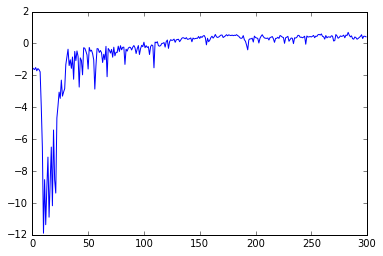

In [11]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])
rMean = np.average(rMat, 1)
plt.plot(rMean)

------------------------------------

## Testing the network performance

This first piece of code aims to make a step by step walkthrough the game to see what actions is taken
For some reason the actor is performing a single action. Need to debug.

In [13]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

In [14]:
sess = tf.InteractiveSession()

In [15]:
ckpt = tf.train.get_checkpoint_state(path)
saver.restore(sess, ckpt.model_checkpoint_path)    

INFO:tensorflow:Restoring parameters from ./dqn_logs/model-29999.cptk


[2017-06-05 16:39:39,215] Restoring parameters from ./dqn_logs/model-29999.cptk


In [16]:
#Reset environment and get the first new observation
s = env.reset()
#s = processState(s)
d = False
rAll_t = 0
j_t = 0        

Action: 1
Reward: 0 , Done: False


TypeError: Invalid dimensions for image data

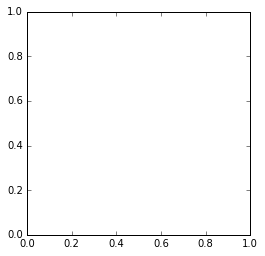

In [17]:
#Choose an action by greedily picking from the Q-net
a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns

print ("Action: %d" % a)
s1, r, d = env.step(a)
print ("Reward: %d , Done: %s" % (r, d))
plt.imshow(s1, interpolation = "nearest")
#s1 = processState(s1)#// flatten the return frame
total_steps_t += 1
                        
rAll_t += r
s = s1


if d == True:
    print("End of training episode")
    jList_t.append(j_t)
    rList_t.append(rAll_t)
            
    if len(rList_t) % 10 == 0:
        accumR = np.mean(rList_t[-10:])
        log = str(total_steps_t) +"\t"+ str(accumR) 
        print(log)            

In [18]:
sess.close()

Test the actor in an automatic way. The issue is the same, the actor chooses the same action constantly

In [12]:
#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

# Test setting parameters
load_model = True
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
with tf.Session() as sess:
    
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess, ckpt.model_checkpoint_path)
    
    for i in range(num_test_episodes):
        
        #Reset environment and get the first new observation
        s = env.reset()
        #s = processState(s)
        d = False
        rAll_t = 0
        j_t = 0
        
        #Q-Network
        while j_t < max_epLength: #If the agent takes longer than 200 moves to reach either of the blocks, end the trail
            j_t+=1
            
            #Choose an action by greedily picking from the Q-net
            a = sess.run(mainQN.predict, feed_dict={mainQN.input:[s]})[0]# //the extra [0] takes the value of the sing-entry array that Main1.predict returns
                
            s1, r, d = env.step(a)
           #s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                        
              
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
            #f.write(log)
                
    
final_log = "Percent of sucessful episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

Loading Model...
INFO:tensorflow:Restoring parameters from ./log4/model-29999.cptk


[2017-06-06 02:00:00,724] Restoring parameters from ./log4/model-29999.cptk


840	0.6
2257	0.3
3097	0.6
4514	0.3
5354	0.6
6771	0.3
7611	0.6
9028	0.3
9868	0.6
11285	0.3
12125	0.6
13542	0.3
14382	0.6
15799	0.3
16639	0.6
18056	0.3
18896	0.6
20313	0.3
21153	0.6
22570	0.3
23410	0.6
24827	0.3
25667	0.6
27084	0.3
27924	0.6
29341	0.3
30181	0.6
31598	0.3
32438	0.6
33855	0.3
34695	0.6
36112	0.3
36952	0.6
38369	0.3
39209	0.6
40626	0.3
41466	0.6
42883	0.3
43723	0.6
45140	0.3
45980	0.6
47397	0.3
48237	0.6
49654	0.3
50494	0.6
51911	0.3
52751	0.6
54168	0.3
55008	0.6
56425	0.3
57265	0.6
58682	0.3
59522	0.6
60939	0.3
61779	0.6
63196	0.3
64036	0.6
65453	0.3
66293	0.6
67710	0.3
68550	0.6
69967	0.3
70807	0.6
72224	0.3
73064	0.6
74481	0.3
75321	0.6
76738	0.3
77578	0.6
78995	0.3
79835	0.6
81252	0.3
82092	0.6
83509	0.3
84349	0.6
85766	0.3
86606	0.6
88023	0.3
88863	0.6
90280	0.3
91120	0.6
92537	0.3
93377	0.6
94794	0.3
95634	0.6
97051	0.3
97891	0.6
99308	0.3
100148	0.6
101565	0.3
102405	0.6
103822	0.3
104662	0.6
106079	0.3
106919	0.6
108336	0.3
109176	0.6
110593	0.3
111433	0.6
112850	0.

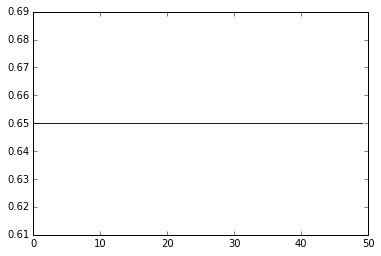

In [20]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)

---------------------------------------------

## Test Random Actor

In [35]:
# Test setting parameters for random actor
num_test_episodes = 5000

#Create lists to contain total reward and steps per episode
jList_t = []
rList_t = []
total_steps_t = 0

_,_ = env.checkGoal()

with tf.Session() as sess:
    sess.run(init)
        
    for i in range(num_test_episodes):
        
        d = False
        rAll_t = 0
        j_t = 0
        
        while j_t < max_epLength: #If the agent takes longer than 50 moves to reach either of the blocks, end the trail
            j_t += 1
            
            a = np.random.randint(0,4)
                
            s1, r, d = env.step(a)
            s1 = processState(s1)#// flatten the return frame
            total_steps_t += 1
                      
            rAll_t += r
            s = s1
                
            if d == True:
                break
                        
        
        jList_t.append(j_t)
        rList_t.append(rAll_t)
            
        if len(rList_t) % 10 == 0:
            accumR = np.mean(rList_t[-10:])
            log = str(total_steps_t) +"\t"+ str(accumR) 
            print(log)
                           
    
final_log = "Percent of sucessful test episodes: " + str(sum(rList_t)/num_test_episodes) + "%"
print(final_log)

62	-0.6
140	-1.0
248	-1.0
367	-0.8
427	-0.8
564	-0.6
607	-0.6
730	-0.9
806	-0.8
891	-0.6
1013	-1.0
1129	-0.8
1209	-0.4
1307	-0.6
1406	-0.9
1508	-0.6
1562	-1.0
1608	-1.0
1751	-0.8
1836	-0.8
1912	-0.6
2003	-0.6
2101	-0.8
2194	-1.0
2268	-1.0
2314	-0.8
2394	-0.6
2477	-1.0
2575	-1.0
2671	-1.0
2753	-0.8
2828	-0.8
2936	-0.8
3003	-1.0
3082	-0.6
3173	-0.6
3318	-0.6
3429	-0.8
3575	-0.5
3740	-0.4
3828	-0.2
3975	-0.8
4082	-1.0
4133	-0.8
4202	-0.8
4267	-0.6
4386	-0.8
4505	-0.4
4626	-0.4
4693	-1.0
4745	-0.8
4792	-0.8
4860	-0.6
4974	-0.9
5031	-0.6
5066	-0.8
5207	-0.8
5313	-0.6
5410	-0.8
5513	-1.0
5582	-0.8
5683	-0.6
5811	-1.0
5865	-0.8
5954	-0.8
6006	-0.2
6121	-1.0
6246	-0.8
6300	-0.8
6394	-0.6
6516	-0.7
6616	-0.8
6679	-0.4
6758	-0.6
6842	-0.4
6887	-0.4
6955	-0.8
7006	-0.6
7111	-0.8
7225	-0.4
7268	-1.0
7397	-0.8
7455	-0.6
7529	-1.0
7564	-0.6
7643	-0.8
7731	-0.8
7886	-1.0
7990	-0.6
8073	-0.8
8120	-0.6
8186	-1.0
8213	-0.8
8283	-0.4
8357	-0.8
8417	-0.8
8510	-1.0
8649	-1.0
8715	-0.4
8798	-0.8
8884	-0.6
8

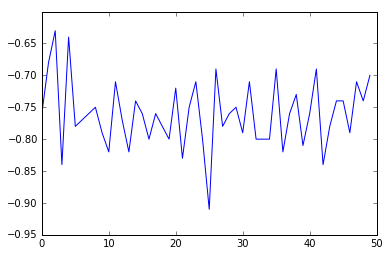

In [34]:
rMat_t = np.resize(np.array(rList_t), [len(rList_t)//100,100])
rMean_t = np.average(rMat_t, 1)
plt.plot(rMean_t)